# Information Retrieval

In [1]:
import ParserCACM
import TextRepresenter
import indexation
import modeles
from query import QueryParserCACM
import evaluation
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import operator

%load_ext autoreload
%autoreload 2
""" Some info to remember when testing:
- Query 10 is about parallel computation
- Doc 46 is about parallelism too
"""

# Constants:
srcFolder = "cacm"
srcFile = "cacm.txt"
qryFile = "cacm.qry"
relFile = "cacm.rel"
gendata = "gendata"
indexName = "cacm"
docId = 46
queryId = np.random.randint(1,60)
wordTest = "logic"

cacm_txt = os.path.join(srcFolder, srcFile)
cacm_qry = os.path.join(srcFolder, qryFile)
cacm_rel = os.path.join(srcFolder, relFile)

## Testing the indexation:

In [2]:
# Construct the index:
idx = indexation.Index(indexName, gendata)
stemmer = TextRepresenter.PorterStemmer()
idx.indexation(cacm_txt, ParserCACM.ParserCACM(),
               stemmer)

Performing the indexation...
1st pass: build the index...
2nd pass: build the inverted index...
Finished.


In [3]:
print("\n###### Testing the index: ###### ")
print("Retrieve common stems in doc %d:" % docId)
stems = sorted(idx.getTfsForDoc(docId).items(), key=operator.itemgetter(1), reverse=True)
print([stem for stem, freq in stems[:10]])
print("""Should look like
> “The tendency towards increased parallelism in
> computers is noted.  Exploitation of this parallelism
> presents a number of new problems in machine design
> and in programming systems...”""")

print("\nRetrieve docs that contains 'logic'")
docs = idx.getTfsForStem("logic") 
print("Should include doc 63 and 46:", (63 in docs.keys() and 46 in docs.keys()))


###### Testing the index: ###### 
Retrieve common stems in doc 46:
['program', 'problem', 'programm', 'logic', 'requir', 'stretch', 'parallel', 'system', 'discuss', 'techniqu']
Should look like
> “The tendency towards increased parallelism in
> computers is noted.  Exploitation of this parallelism
> presents a number of new problems in machine design
> and in programming systems...”

Retrieve docs that contains 'logic'
Should include doc 63 and 46: True


In [4]:
# Chosing what to test:
test_binaryweighter = True
test_tfidfweighter = True
test_queryparser = True
test_PRrecallmeasure = True
test_averageprecision = True
test_eval_ir_model = True


## Testing the weighters:

In [5]:
query = stemmer.getTextRepresentation(" Parallel languages; languages for parallel computation")

if test_binaryweighter:
    print("\n#####Testing BinaryWeighter: #####")

    bw = modeles.BinaryWeighter(idx)
    print("bw.getDocWeightsForDoc(",docId,"):", 
        bw.getDocWeightsForDoc(docId))
    print("\nbw.getDocWeightsForStem('"+wordTest+"'):", 
        bw.getDocWeightsForStem(wordTest))
    print("\nbw.getWeightsForQuery(' Parallel languages; languages for parallel computation'):", 
        bw.getWeightsForQuery(query))

    print("\n#####Testing Vectoriel with BinaryWeighter: #####")
    vect = modeles.Vectoriel(idx, bw)
    print("Top 10 documents for the previous query:")
    print(vect.getRanking(query)[:10])
else:
    print("\n##### Skipping the test of BinaryWeighter #####")
    


#####Testing BinaryWeighter: #####
bw.getDocWeightsForDoc( 46 ): {'system': 1, 'discuss': 1, 'techniqu': 1, 'exploit': 1, 'carefulli': 1, 'multiprogramm': 1, 'describ': 1, 'consider': 1, 'scalzi': 1, 'design': 1, 'met': 1, 'feasibl': 1, 'mcdonough': 1, 'success': 1, 'logic': 2, 'note': 1, 'built': 1, 'requir': 2, 'comput': 1, 'stretch': 2, 'balanc': 1, 'lowri': 1, 'burden': 1, 'combin': 1, 'place': 1, 'execut': 1, 'program': 4, 'problem': 3, 'codd': 1, 'compil': 1, 'machin': 1, 'tendenc': 1, 'programm': 3, 'parallel': 2, 'supervisori': 1, 'minimum': 1, 'independ': 1, 'number': 1, 'increas': 1, 'present': 1, 'concurr': 1}

bw.getDocWeightsForStem('logic'): {2817: 1, 3154: 6, 1030: 1, 2568: 1, 2313: 2, 3082: 1, 2060: 1, 2322: 1, 2067: 1, 22: 1, 2845: 1, 30: 1, 2848: 3, 2851: 1, 2054: 1, 3111: 1, 1834: 1, 1324: 1, 46: 2, 1327: 1, 2952: 1, 2871: 4, 3133: 5, 63: 2, 320: 8, 1602: 2, 2230: 1, 2888: 1, 3147: 1, 1101: 1, 2127: 2, 850: 1, 595: 2, 753: 1, 2145: 1, 2146: 2, 1381: 1, 2406: 3, 1383

In [6]:
tfidfWeighter = modeles.TfidfWeighter(idx)
vect = modeles.Vectoriel(idx, tfidfWeighter)

if test_tfidfweighter:
    print("\n###### Testing TfidfWeighter: ###### ")
    print("tfidfWeighter.getDocWeightsForDoc(", docId, "):",
         tfidfWeighter.getDocWeightsForDoc(docId))
    print("\ntfidfWeighter.getDocWeightsForStem(\"logic\"):",
         tfidfWeighter.getDocWeightsForStem(wordTest))
    print("\ntfidfWeighter.getWeightsForQuery(query):",
         tfidfWeighter.getWeightsForQuery(query))
    print("\n###### Testing Vectoriel with TfidfWeighter: ###### ")
    print("Top 10 documents for the query:")
    print(vect.getRanking(query)[:10])
else:
    print("\n##### Skipping the test of TfidfWeighter #####")
    


###### Testing TfidfWeighter: ###### 
tfidfWeighter.getDocWeightsForDoc( 46 ): {'system': 1, 'discuss': 1, 'techniqu': 1, 'exploit': 1, 'carefulli': 1, 'multiprogramm': 1, 'describ': 1, 'consider': 1, 'scalzi': 1, 'design': 1, 'met': 1, 'feasibl': 1, 'mcdonough': 1, 'success': 1, 'logic': 2, 'note': 1, 'built': 1, 'requir': 2, 'comput': 1, 'stretch': 2, 'balanc': 1, 'lowri': 1, 'burden': 1, 'combin': 1, 'place': 1, 'execut': 1, 'program': 4, 'problem': 3, 'codd': 1, 'compil': 1, 'machin': 1, 'tendenc': 1, 'programm': 3, 'parallel': 2, 'supervisori': 1, 'minimum': 1, 'independ': 1, 'number': 1, 'increas': 1, 'present': 1, 'concurr': 1}

tfidfWeighter.getDocWeightsForStem("logic"): {2817: 1, 3154: 6, 1030: 1, 2568: 1, 2313: 2, 3082: 1, 2060: 1, 2322: 1, 2067: 1, 22: 1, 2845: 1, 30: 1, 2848: 3, 2851: 1, 2054: 1, 3111: 1, 1834: 1, 1324: 1, 46: 2, 1327: 1, 2952: 1, 2871: 4, 3133: 5, 63: 2, 320: 8, 1602: 2, 2230: 1, 2888: 1, 3147: 1, 1101: 1, 2127: 2, 850: 1, 595: 2, 753: 1, 2145: 1, 2146: 

## Testing the QueryParser

In [7]:
if test_queryparser:
    print("\n###### Testing QueryParserCACM: ###### ")
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #%d:" % queryId)
    while query is not None and query.getID() != str(queryId):
        #print(query)
        #print(20*'-')
        query = qp.nextQuery()

    print("Query:", query)
    queryTxt = stemmer.getTextRepresentation(query.getText())
    print("\nCompute scores:")
    scores = vect.getRanking(queryTxt)
    print(scores[:10])
    print("Done.")
else:
    print("\n##### Skipping the test of QueryParserCACM #####")
    


###### Testing QueryParserCACM: ###### 
Searching for query #17:
Query: Query {id=17, txt='Optimization of intermediate and machine code
', relevances=[2579, 1947, 1223, 1231, 2923, 2495, 1613, 1934, 1807, 1134, 2290, 115, 405, 2586, 1551, 1535]}

Compute scores:
[('1795', 0.39123686369640354), ('2491', 0.39046017710896413), ('2897', 0.35821195639257125), ('2495', 0.32796547020229633), ('2748', 0.31798907974972157), ('2079', 0.31261662863316725), ('2117', 0.30318802267539663), ('195', 0.26999115966742632), ('2464', 0.26009312655217814), ('1154', 0.25879353538608929)]
Done.


## Testing measures:



###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 10, 25]
Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[3141, 2376, 3148, 3082, 2700, 2895, 2320, 2578, 1877, 2777, 2618, 2597, 2912, 2256, 3043, 2342, 2150, 2280, 2866, 1198, 2941, 2865, 2482, 1960, 2228, 3128, 1338, 2685]}
Retrieve scores...
CPU times: user 220 ms, sys: 80 ms, total: 300 ms
Wall time: 362 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 28 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.035714
    2|   2 | 1.000000  |0.071429
    3|   2 | 0.666667  |0.071429
    4|   3 | 0.750000  |0.107143
    5|   3 | 0.600000  |0.107143
    6|   3 | 0.500000  |0.107143
    7|   3 | 0.428571  |0.10

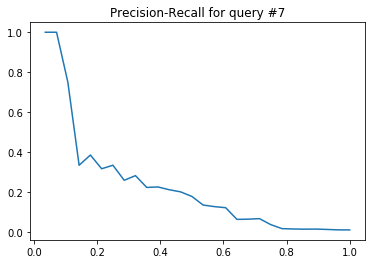

--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[2896, 1601, 1795, 3075, 1158, 2433, 2376, 2700, 2060, 1613, 141, 2256, 1747, 3156, 1262, 2777, 2714, 2895, 3039, 2912, 2785, 2851, 1380, 2342, 2150, 2289, 2664, 46, 1198, 392, 1811, 950, 2618, 2685, 1471]}
Retrieve scores...
CPU times: user 276 ms, sys: 148 ms, total: 424 ms
Wall time: 439 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 35 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.028571
    2|   2 | 1.000000  |0.057143
    3|   3 | 1.000000  |0.085714
    4|   4 | 1.000000  |0.114286
    5|   5 | 1.000000  |0.142857
    6|   5 | 0.833333  |0.142857
    7|   5 | 0.714286  |0.142857
    8|   6 | 0.750000  |0.171429
    9|   7 | 0.777778  |0.200000
   10|   8 | 0.800000  |0.228571
   11|   9 | 0.818182  |0.257143
   12|  10 | 0.833333  |0.285714
   13|  11 | 0.846154  |0.314286
   14|  11 | 0.785714  |0.314286
  

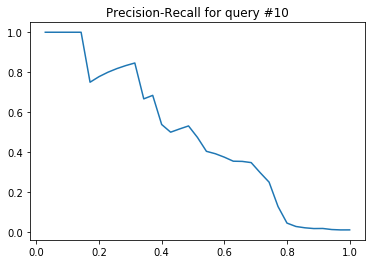

--------------------
Query: Query {id=25, txt='Performance evaluation and modelling of computer systems
', relevances=[1408, 2434, 1901, 268, 1805, 2318, 2319, 3088, 3089, 2452, 1518, 2582, 2818, 2095, 1698, 1572, 2085, 2984, 2218, 2859, 2988, 2862, 2863, 2996, 2741, 2358, 1719, 3006, 1653, 2881, 963, 2373, 2765, 2831, 1892, 2277, 2918, 2535, 3048, 3119, 2667, 2668, 2669, 2798, 2928, 3059, 757, 1526, 2681, 3067, 1533]}
Retrieve scores...
CPU times: user 272 ms, sys: 104 ms, total: 376 ms
Wall time: 430 ms
Create PrecisionRecallMeasure object
Evaluate the scores.
This query has 51 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.019608
    2|   2 | 1.000000  |0.039216
    3|   2 | 0.666667  |0.039216
    4|   3 | 0.750000  |0.058824
    5|   4 | 0.800000  |0.078431
    6|   5 | 0.833333  |0.098039
    7|   6 | 0.857143  |0.117647
    8|   6 | 0.750000  |0.117647
    9|   6 | 0.666667  |0.117647
   10|   6 | 0.600000  |0.117647
   11|   7 | 0.636364  |0.137255
 

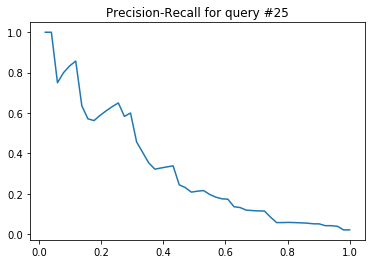

--------------------
Done.


In [8]:
if test_PRrecallmeasure:
    print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
    queryChosen = np.random.randint(1, 50, size=10)
    queryChosen =[7, 10, 25]#, 14, 26, 27, 42, 43] # lots of relevant results
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #", queryChosen)
    while query is not None :
        if int(query.getID()) in queryChosen:
            print("Query:", query)
            queryTxt = stemmer.getTextRepresentation(query.getText())
            print("Retrieve scores...")
            %time scores = vect.getRanking(queryTxt)
            print("Create PrecisionRecallMeasure object")
            irlist = evaluation.IRList(query, scores)
            precisRecall = evaluation.PrecisionRecallMeasure(irlist)
            print("Evaluate the scores.")
            pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
            precision = [p for r,p in pr]
            recall = [r for r,p in pr]
            plt.plot(recall, precision)
            plt.title("Precision-Recall for query #"+query.getID())
            plt.show()
            print(20*'-')


        query = qp.nextQuery()
    print("Done.")
else:
    print("\n##### Skipping the test of PrecisionRecallMeasure #####")
    

In [14]:
if test_averageprecision:
    print("\n###### Testing evaluation.AveragePrecision: ###### ")
    queryChosen = np.random.randint(1, 50, size=10)
    queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for query #",queryChosen, "\n")
    while query is not None :
        if int(query.getID()) in queryChosen:
            print("Query:", query)
            queryTxt = stemmer.getTextRepresentation(query.getText())
            print("Retrieve scores...")
            scores = vect.getRanking(queryTxt)
            irlist = evaluation.IRList(query, scores)
            average_measure = evaluation.AveragePrecision(irlist)
            print("Evaluate the scores.")
            average_prec = average_measure.eval(verbose=True)
            print("Average precision: %f" % average_prec)
            print(20*'-')

        query = qp.nextQuery()
    print("Done.")
else:
    print("\n##### Skipping the test of AveragePrecision #####")



###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [7, 10, 14] 

Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[3141, 2376, 3148, 3082, 2700, 2895, 2320, 2578, 1877, 2777, 2618, 2597, 2912, 2256, 3043, 2342, 2150, 2280, 2866, 1198, 2941, 2865, 2482, 1960, 2228, 3128, 1338, 2685]}
Retrieve scores...
Evaluate the scores.
This query has 28 relevant results
[3141, 2376, 3148, 3082, 2700, 2895, 2320, 2578, 1877, 2777, 2618, 2597, 2912, 2256, 3043, 2342, 2150, 2280, 2866, 1198, 2941, 2865, 2482, 1960, 2228, 3128, 1338, 2685]
   i |found| precision
    1|   1 | 1.000000
    2|   2 | 1.000000
3104 not in trueRels
    4|   3 | 0.750000
1353 not in trueRels
3170 not in trueRels
2896 not in trueRels
2212 not in trueRels
2914

In [31]:

if test_eval_ir_model:
    print("\n###### Testing evaluation.EvalIRModel: ###### ")
    queryChosen = np.random.randint(1, 50, size=10)
    queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
    queries = []
    qp = QueryParserCACM(cacm_qry, cacm_rel)
    query = qp.nextQuery()
    print("Searching for queries #",queryChosen, "...")
    while query is not None :
        if int(query.getID()) in queryChosen:
            queries.append(query)
        query = qp.nextQuery()
    print("Found queries")
    irmodels = {"vectoriel": modeles.Vectoriel(idx, tfidfWeighter)}
    measures = {"averagePrecision": evaluation.AveragePrecision}
    eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
    print("Calling eval()...")
    print(eval_model.eval(verbose=False))
    print("Done.")
else:
    print("\n##### Skipping the test of EvalIRModel #####")



###### Testing evaluation.EvalIRModel: ###### 
Searching for queries # [7, 10, 14] ...
Found queries
Calling eval()...
{('vectoriel', 'averagePrecision'): (0.38668853949931165, 0.1127990142986723)}
Done.
